In [28]:
#!pip install numpy
#!pip install matplotlib
#!pip install graphviz
#!pip install jupyter_contrib_nbextensions # https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html

In [29]:
import math
import random
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges: # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [31]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        '''
        Value is a wrapper of a python float.
        Value defines a 'variable' for which can be computed a
        derivative wrt the output of a computation.
        To do so, Value keeps track of how it has been computed.
        Backprop is just: local gradient * chained gradient

        out
         |
        _op
        /  \
       v1   v2

        _children: tuple of Values, if the Value obj is the output of some
        supported operation. default: empty tuple for leaf nodes
        _op: char, the symbol of the operation, default empty for leaf nodes

        dmembers:
        data: stores the value of the Value
        _prev: set of _children
        _op: char, if self is the result of some supported operation, then the operation
        is stored in _op
        grad: float, gradient of self wrt a root value on which .backward() has been called
        _backward: function to be called to compute grad of self
        label: name to be shown in computation graph
        '''
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): return f"Value(data={self.data})"

    def __add__(self, other):
        # out.grad is filled because its grad has already been computed
        # because it is closer to the output root wrt which .backward() has been called
        # + op "distributes" gradient
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        # * op "distributes and scales" gradient
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward(): self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): return self * other # other * self
    def __truediv__(self, other): return self * other**-1 # self / other
    def __neg__(self): return self * -1 # -self
    def __sub__(self, other): return self + (-other) # self - other
    def __radd__(self, other): return self + other # other + self

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # each _backward is composed by:
            # local derivative * grad coming from root
            local_derivative = (1 - t**2)
            self.grad +=  local_derivative * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward(): self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo): node._backward()

In [32]:
class Neuron:
    def __init__(self, inp_dim):
        '''
        A single neuron of the layer. It takes as input the whole feature vector.
        Applied dot prod between x and w, then sums a scalar bias
        '''
        self.w = [Value(random.uniform(-1, 1)) for _ in range(inp_dim)]
        self.b = Value(random.uniform(-1, 1))

    def parameters(self): return self.w + [self.b]

    def __call__(self, x):
        # x in R**n; w in R**n; b in R
        # x*w + b
        act = sum([wi * xi for wi, xi in list(zip(self.w, x))], self.b)
        out = act.tanh()
        return out

In [33]:
class Layer:
    def __init__(self, inp_dim, out_dim):
        self.neurons = [Neuron(inp_dim) for neuron in range(out_dim)]

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

In [34]:
class MLP:
    def __init__(self, inp_dim, out_dims_list):
        sz = [inp_dim] + out_dims_list
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(out_dims_list))] # or sz-1

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [35]:
# let's build a fake dataset:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [36]:
mlp = MLP(3, [4, 4, 1])
for k in range(40):

    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    # flush grads
    for p in mlp.parameters():
        p.grad = 0.0

    print(k, loss.data)

0 2.5626886450463697
1 0.10408435109499127
2 0.04709481614130762
3 0.03679902950189163
4 0.030709760503850846
5 0.026488450154478566
6 0.023337775953966754
7 0.020879289985427485
8 0.018900935567508353
9 0.017271698630172153
10 0.015905241288327234
11 0.014741962950839944
12 0.013739231357553599
13 0.012865672152178341
14 0.012097647725879547
15 0.011416992839964942
16 0.010809507819635897
17 0.010263926824618705
18 0.009771194003052349
19 0.009323944825965248
20 0.008916127497045108
21 0.008542722031870419
22 0.00819952872398933
23 0.007883006735816905
24 0.007590149448566937
25 0.007318387139683895
26 0.0070655102303882975
27 0.006829608194291308
28 0.006609020515223967
29 0.006402297005609826
30 0.006208165462213592
31 0.006025505121567544
32 0.005853324735435877
33 0.005690744353471281
34 0.00553698010092114
35 0.005391331391573823
36 0.005253170132728314
37 0.005121931568913136
38 0.0049971064809785125
39 0.004878234511888095


In [37]:
ypred

[Value(data=0.9637626869874116),
 Value(data=-0.9730186619684424),
 Value(data=-0.9592094080195499),
 Value(data=0.9657476035666546)]

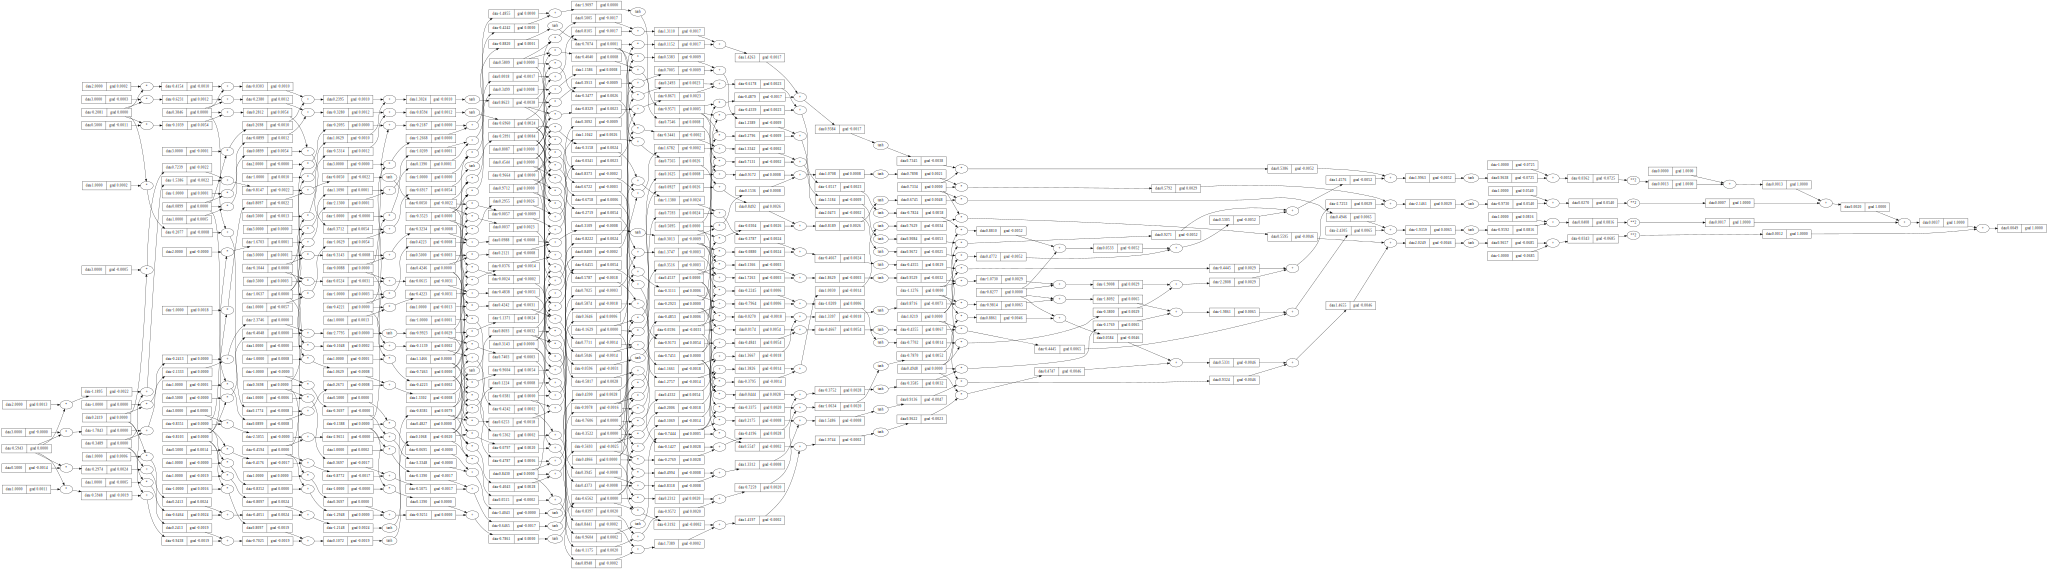

In [38]:
draw_dot(loss)